In [93]:
#Load dataframe tools
import pandas as pd
import numpy as np
%matplotlib inline

# Load webscaraping tools
import requests
import bs4

# Load forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load plotting tools
from pylab import rcParams
from matplotlib import pyplot as plt

# Load regex tools

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Collecting data. 
The are numerous data sources available online. Free downloadable sales revenue data can be hard to come by. Howevever, If you're lucky you may come across a website such as <a href="https://www.macrotrends.net/">macrotrends</a> that might have the data available in a table format. This is where python shines because we can scrape the webpage for the table data.

### Scraping the data

In [39]:
result = requests.get("https://www.macrotrends.net/stocks/charts/GME/gamestop/revenue")
soup = bs4.BeautifulSoup(result.text,"lxml")

In [ ]:
#Get the HTML information
soup

### Table Extraction
Fortunately, Pandas has a webscraping feature. So we can skip a lot lines of code that we would have had to use to perform the same task with BeautifulSoup.

In [79]:
table = soup.find_all('table')
df = pd.read_html(str(table))[1] #since there is more than one table on the webpage, we need to reference which table we want by calling its index.

In [80]:
# Preview the dataframe
df.head()

,GameStop Quarterly Revenue(Millions of US $),GameStop Quarterly Revenue(Millions of US $).1
0,2020-07-31,$942
1,2020-04-30,"$1,021"
2,2020-01-31,"$2,194"
3,2019-10-31,"$1,439"
4,2019-07-31,"$1,286"


In [56]:
df.dtypes

GameStop Quarterly Revenue(Millions of US $)      object
GameStop Quarterly Revenue(Millions of US $).1    object
dtype: object

### Transforming the data
As you can see, there is some cleaning up of data in our dataframe that we need to do before we can conduct our analysis. We will need to do the following:<br>
1. Rename the date column<br>
2. Change the format of the dates to datetime64<br>
3. Datetime index the dates column and specify a quarterly frequency<br>
4. Change the format of the revenue column entries from an object to numerical items

In [81]:
#Changing dates format to datetime64 and renaming the field
df['Date'] = pd.to_datetime(df['GameStop Quarterly Revenue(Millions of US $)'], errors='coerce', format='%Y-%m-%d')
df.set_index('Date',inplace=True)
#df = df.sort_index()

In [83]:
df.sort_index(inplace=True)

In [84]:
df.head()

,GameStop Quarterly Revenue(Millions of US $),GameStop Quarterly Revenue(Millions of US $).1
Date,,
2005-01-31,2005-01-31,$709
2005-04-30,2005-04-30,$475
2005-07-31,2005-07-31,$416
2005-10-31,2005-10-31,$534
2006-01-31,2006-01-31,"$1,667"


In [85]:
# Transforming the revenue column
df['GameStop Quarterly Revenue(Millions of US $)'] = df['GameStop Quarterly Revenue(Millions of US $).1'].str.replace(r'\D+', '').astype('int')

In [86]:
# Preview the dataframe again
df.head()

,GameStop Quarterly Revenue(Millions of US $),GameStop Quarterly Revenue(Millions of US $).1
Date,,
2005-01-31,709,$709
2005-04-30,475,$475
2005-07-31,416,$416
2005-10-31,534,$534
2006-01-31,1667,"$1,667"


In [87]:
df = df.drop('GameStop Quarterly Revenue(Millions of US $).1', 1)

In [88]:
df.head()

,GameStop Quarterly Revenue(Millions of US $)
Date,
2005-01-31,709
2005-04-30,475
2005-07-31,416
2005-10-31,534
2006-01-31,1667


# Analysis

### 1. Plot the source data

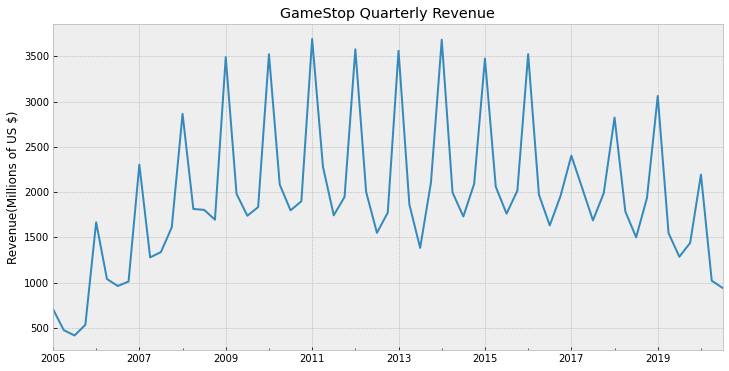

In [89]:
title = 'GameStop Quarterly Revenue'
ylabel='Revenue(Millions of US $)'
xlabel='' # we don't really need a label here

plt.style.use('bmh')
ax = df['GameStop Quarterly Revenue(Millions of US $)'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### 2. Run an ETS Decomposition

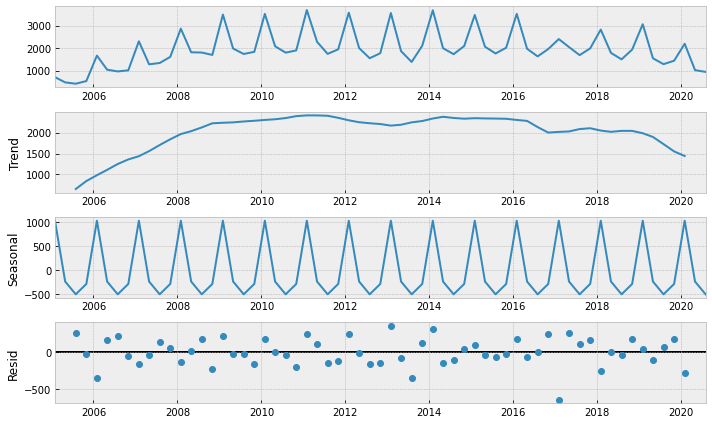

In [95]:
result = seasonal_decompose(df, model='add')
rcParams['figure.figsize']=10,6
result.plot();

### 3. Automate the augmented Dickey-Fuller Test

In [100]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [102]:
adf_test(df['GameStop Quarterly Revenue(Millions of US $)'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.693110
p-value                  0.434666
# lags used              5.000000
# observations          57.000000
critical value (1%)     -3.550670
critical value (5%)     -2.913766
critical value (10%)    -2.594624
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [103]:
df_transformed = df.diff().dropna()

In [105]:
df_transformed.head()

,GameStop Quarterly Revenue(Millions of US $)
Date,
2005-04-30,-234.0
2005-07-31,-59.0
2005-10-31,118.0
2006-01-31,1133.0
2006-04-30,-627.0


In [104]:
adf_test(df_transformed['GameStop Quarterly Revenue(Millions of US $)'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.684502
p-value                  0.076759
# lags used              4.000000
# observations          57.000000
critical value (1%)     -3.550670
critical value (5%)     -2.913766
critical value (10%)    -2.594624
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Since Revenue is still not stationary, we'll apply second order differencing to both series so they retain the same number of observations

In [106]:
df_transformed = df_transformed.diff().dropna()
adf_test(df_transformed['GameStop Quarterly Revenue(Millions of US $)'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -5.428494
p-value                  0.000003
# lags used              6.000000
# observations          54.000000
critical value (1%)     -3.557709
critical value (5%)     -2.916770
critical value (10%)    -2.596222
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders

In [126]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['GameStop Quarterly Revenue(Millions of US $)'],m=4,seasonal=False,start_q=1,max_q=1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   63
Model:               SARIMAX(3, 2, 1)   Log Likelihood                -430.354
Date:                Wed, 07 Oct 2020   AIC                            870.708
Time:                        09:45:00   BIC                            881.263
Sample:                             0   HQIC                           874.845
                                 - 63                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9896      0.048    -20.610      0.000      -1.084      -0.896
ar.L2         -0.9878      0.043    -23.034      0.000      -1.072      -0.904
ar.L3         -0.9512      0.038    -24.890      0.000      -1.026      -0.876
ma.L1         -0.6543      0.094     -6.938      0.000      -0.839      -0.469
sigma2      7.026e+04   1.25e+04      5.633      0.000    4.58e+04    9.47e+04
===================================================================================
Ljung-Box (Q):                       25.68   Jarque-Bera (JB):                 7.40
Prob(Q):                              0.96   Prob(JB):                         0.02
Heteroskedasticity (H):               2.41   Skew:                            -0.38
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [113]:
df_transformed

,GameStop Quarterly Revenue(Millions of US $)
Date,
2005-07-31,175.0
2005-10-31,177.0
2006-01-31,1015.0
2006-04-30,-1760.0
2006-07-31,550.0
...,...
2019-07-31,1253.0
2019-10-31,415.0
2020-01-31,602.0


### Train/test split

In [114]:
nobs=4
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

In [115]:
print(train.shape)
print(test.shape)

(57, 1)
(4, 1)


In [131]:
model = ARIMA(train,order=(3,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           ARIMA Model Results                                            
==========================================================================================================
Dep. Variable:     D.GameStop Quarterly Revenue(Millions of US $)   No. Observations:                   56
Model:                                             ARIMA(3, 1, 1)   Log Likelihood                -420.786
Method:                                                   css-mle   S.D. of innovations                nan
Date:                                            Wed, 07 Oct 2020   AIC                            853.572
Time:                                                    10:10:54   BIC                            865.724
Sample:                                                10-31-2005   HQIC                           858.283
                                                     - 07-31-2019                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    1.2211      0.867      1.409      0.159      -0.477       2.919
ar.L1.D.GameStop Quarterly Revenue(Millions of US $)    -1.0462   7.09e-05  -1.48e+04      0.000      -1.046      -1.046
ar.L2.D.GameStop Quarterly Revenue(Millions of US $)    -1.0462    7.1e-05  -1.47e+04      0.000      -1.046      -1.046
ar.L3.D.GameStop Quarterly Revenue(Millions of US $)    -1.0000   1.59e-05  -6.29e+04      0.000      -1.000      -1.000
ma.L1.D.GameStop Quarterly Revenue(Millions of US $)    -0.9323      0.085    -11.000      0.000      -1.098      -0.766
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0000           -0.0000j            1.0000           -0.5000
AR.2           -0.0231           -0.9997j            1.0000           -0.2537
AR.3           -0.0231           +0.9997j            1.0000            0.2537
MA.1            1.0726           +0.0000j            1.0726            0.0000
-----------------------------------------------------------------------------
"""

### Obtain Predicted Values

In [132]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(3,2,1) Predictions')

In [139]:
df_forecast = pd.DataFrame(predictions) # create a dataframe from the prediction results
comparison = df_forecast.join(test)
comparison.columns=['Predicted','Expected']

In [140]:
df_forecast.columns = ['Revenue2D']
df_forecast

,Revenue2D
2019-10-31,814.474707
2020-01-31,539.116099
2020-04-30,-2604.926114
2020-07-31,1416.090138


In [135]:
comparison

,Predicted,Expected
2019-10-31,814.474707,415.0
2020-01-31,539.116099,602.0
2020-04-30,-2604.926114,-1928.0
2020-07-31,1416.090138,1094.0


### Invert the Transformation

In [141]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Revenue1D'] = (df['GameStop Quarterly Revenue(Millions of US $)'].iloc[-nobs-1]-df['GameStop Quarterly Revenue(Millions of US $)'].iloc[-nobs-2]) + df_forecast['Revenue2D'].cumsum()

In [142]:
# Now build the forecast values from the first difference set
df_forecast['RevenueForecast'] = df['GameStop Quarterly Revenue(Millions of US $)'].iloc[-nobs-1] + df_forecast['Revenue1D'].cumsum()

In [143]:
df_forecast

,Revenue2D,Revenue1D,RevenueForecast
2019-10-31,814.474707,552.474707,1838.474707
2020-01-31,539.116099,1091.590805,2930.065512
2020-04-30,-2604.926114,-1513.335309,1416.730204
2020-07-31,1416.090138,-97.245171,1319.485033


### Plot the results

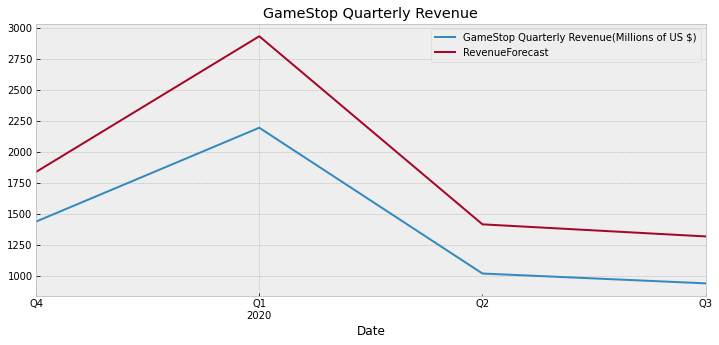

In [149]:
# Plot predictions against known values
title = 'GameStop Quarterly Revenue'
df['GameStop Quarterly Revenue(Millions of US $)'][-nobs:].plot(figsize=(12,5),legend=True,title=title).autoscale(axis='x',tight=True)
df_forecast['RevenueForecast'].plot(legend=True);

### Evaluate the Model

In [150]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(df['GameStop Quarterly Revenue(Millions of US $)'][-nobs:], df_forecast['RevenueForecast'])
print(f'SARIMA (0,1,1)(0,1,0,4) MSE Error: {error:11.10}')

ARIMA(3,2,1) MSE Error: 250117.4561


In [151]:
from statsmodels.tools.eval_measures import rmse

error = rmse(df['GameStop Quarterly Revenue(Millions of US $)'][-nobs:], df_forecast['RevenueForecast'])
print(f'ARIMA(3,2,1) RMSE Error: {error:11.10}')

ARIMA(3,2,1) RMSE Error: 500.1174423


### Retrain the model on the full data, and forecast the future

In [153]:
model = ARIMA(df['GameStop Quarterly Revenue(Millions of US $)'],order=(3,2,1))
results = model.fit()
fcast = results.predict(len(df),len(df)+3,typ='levels').rename('ARIMA(3,2,1) Forecast')

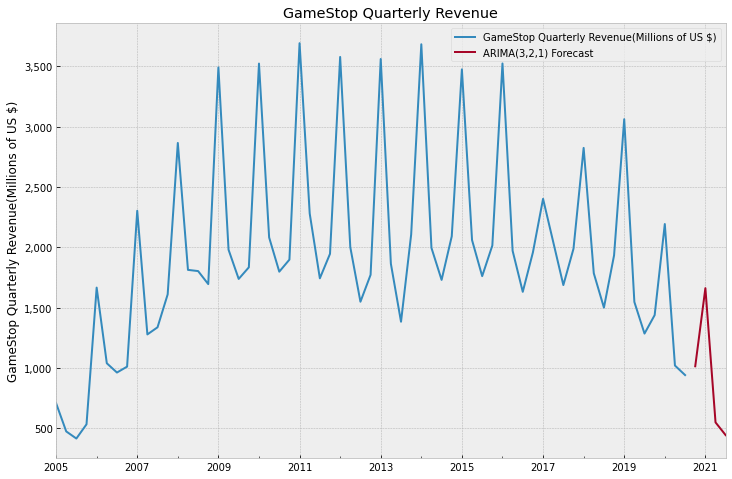

In [161]:
# Plot predictions against known values
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')
title = 'GameStop Quarterly Revenue'
ylabel='GameStop Quarterly Revenue(Millions of US $)'
xlabel='' # we don't really need a label here

ax = df['GameStop Quarterly Revenue(Millions of US $)'].plot(legend=True,figsize=(12,8),title=title)
fcast.plot(legend=True)
plt.legend(loc='upper right')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Let's compare these results to a seasonal ARIMA model

In [156]:
table = soup.find_all('table')
df = pd.read_html(str(table))[1]

In [158]:
#Changing dates format to datetime64 and renaming the field
df['Date'] = pd.to_datetime(df['GameStop Quarterly Revenue(Millions of US $)'], errors='coerce', format='%Y-%m-%d')
df.set_index('Date',inplace=True)
df.sort_index(inplace=True)

In [159]:
# Transforming the revenue column
df['GameStop Quarterly Revenue(Millions of US $)'] = df['GameStop Quarterly Revenue(Millions of US $).1'].str.replace(r'\D+', '').astype('int')

In [165]:
df = df.drop('GameStop Quarterly Revenue(Millions of US $).1', 1)
df.head()

,GameStop Quarterly Revenue(Millions of US $)
Date,
2005-01-31,709
2005-04-30,475
2005-07-31,416
2005-10-31,534
2006-01-31,1667


## Analysis

### Run augmented Dickey-Fuller Test on 2nd order difference
Since we already know that our data achieves stationarity after the second differencing, there is no need to to difference twice. Instead, we can use the built in 2nd order differencing method in statsmodels.

In [166]:
from statsmodels.tsa.statespace.tools import diff
df_transformed = diff(df,k_diff=2)

adf_test(df_transformed)

Augmented Dickey-Fuller Test: 
ADF test statistic      -5.428494
p-value                  0.000003
# lags used              6.000000
# observations          54.000000
critical value (1%)     -3.557709
critical value (5%)     -2.916770
critical value (10%)    -2.596222
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders

In [168]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['GameStop Quarterly Revenue(Millions of US $)'],m=4,seasonal=True,start_q=1,max_q=1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   63
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                -403.101
Date:                           Wed, 07 Oct 2020   AIC                            814.202
Time:                                   14:45:14   BIC                            822.444
Sample:                                        0   HQIC                           817.413
                                            - 63                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -17.7858      7.524     -2.364      0.018     -32.532      -3.040
ma.L1         -0.7138      0.106     -6.760      0.000      -0.921      -0.507
ma.S.L4       -0.3026      0.158     -1.912      0.056      -0.613       0.008
sigma2      6.279e+04   8605.438      7.296      0.000    4.59e+04    7.97e+04
===================================================================================
Ljung-Box (Q):                       24.39   Jarque-Bera (JB):                23.07
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Train/test split

In [169]:
nobs=4
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

In [171]:
model = SARIMAX(train['GameStop Quarterly Revenue(Millions of US $)'],order=(0,1,1),seasonal_order=(0,1,0,4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            SARIMAX Results                                             
========================================================================================================
Dep. Variable:     GameStop Quarterly Revenue(Millions of US $)   No. Observations:                   57
Model:                           SARIMAX(0, 1, 1)x(0, 1, [], 4)   Log Likelihood                -403.982
Date:                                          Wed, 07 Oct 2020   AIC                            811.965
Time:                                                  14:50:43   BIC                            815.867
Sample:                                              07-31-2005   HQIC                           813.461
                                                   - 07-31-2019                                         
Covariance Type:                                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9998      0.112     -8.946      0.000      -1.219      -0.781
sigma2      3.042e+05   3.67e-07   8.28e+11      0.000    3.04e+05    3.04e+05
===================================================================================
Ljung-Box (Q):                      103.47   Jarque-Bera (JB):                41.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.55   Skew:                             0.74
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.95e+26. Standard errors may be unstable.
"""

### Obtain Predicted Values

In [172]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,1)(0,1,0,4) Predictions')

In [173]:
df_forecast = pd.DataFrame(predictions) # create a dataframe from the prediction results
comparison = df_forecast.join(test)
comparison.columns=['Predicted','Expected']

In [174]:
df_forecast.columns = ['Revenue2D']
df_forecast

,Revenue2D
2019-10-31,717.940327
2020-01-31,692.940327
2020-04-30,-2644.059673
2020-07-31,1251.940327


In [175]:
comparison

,Predicted,Expected
2019-10-31,717.940327,415.0
2020-01-31,692.940327,602.0
2020-04-30,-2644.059673,-1928.0
2020-07-31,1251.940327,1094.0


### Invert the Transformation

In [176]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Revenue1D'] = (df['GameStop Quarterly Revenue(Millions of US $)'].iloc[-nobs-1]-df['GameStop Quarterly Revenue(Millions of US $)'].iloc[-nobs-2]) + df_forecast['Revenue2D'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['RevenueForecast'] = df['GameStop Quarterly Revenue(Millions of US $)'].iloc[-nobs-1] + df_forecast['Revenue1D'].cumsum()

df_forecast

,Revenue2D,Revenue1D,RevenueForecast
2019-10-31,717.940327,455.940327,1741.940327
2020-01-31,692.940327,1148.880653,2890.820980
2020-04-30,-2644.059673,-1495.179020,1395.641960
2020-07-31,1251.940327,-243.238694,1152.403266


### Plot the results

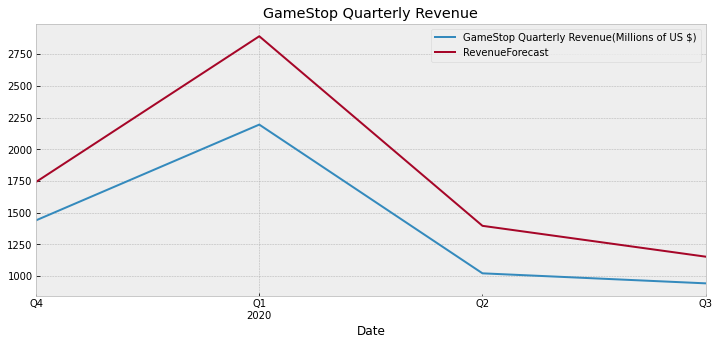

In [177]:
# Plot predictions against known values
title = 'GameStop Quarterly Revenue'
df['GameStop Quarterly Revenue(Millions of US $)'][-nobs:].plot(figsize=(12,5),legend=True,title=title).autoscale(axis='x',tight=True)
df_forecast['RevenueForecast'].plot(legend=True);

### Evaluate the Model

In [178]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

error = mean_squared_error(df['GameStop Quarterly Revenue(Millions of US $)'][-nobs:], df_forecast['RevenueForecast'])
print(f'ARIMA(3,2,1) MSE Error: {error:11.10}')

error = rmse(df['GameStop Quarterly Revenue(Millions of US $)'][-nobs:], df_forecast['RevenueForecast'])
print(f'ARIMA(3,2,1) RMSE Error: {error:11.10}')

ARIMA(3,2,1) MSE Error:  190489.613
ARIMA(3,2,1) RMSE Error: 436.4511576


Based on the the results above, the seasonal ARIMA model performs a little bit better than the ARIMA model.

### Retrain the model on the full data, and forecast the future

In [180]:
model = SARIMAX(df['GameStop Quarterly Revenue(Millions of US $)'],order=(0,1,1),seasonal_order=(0,1,0,4))
results = model.fit()
fcast = results.predict(len(df),len(df)+3,typ='levels').rename('SARIMA(0,1,1)(0,1,0,4) Forecast')

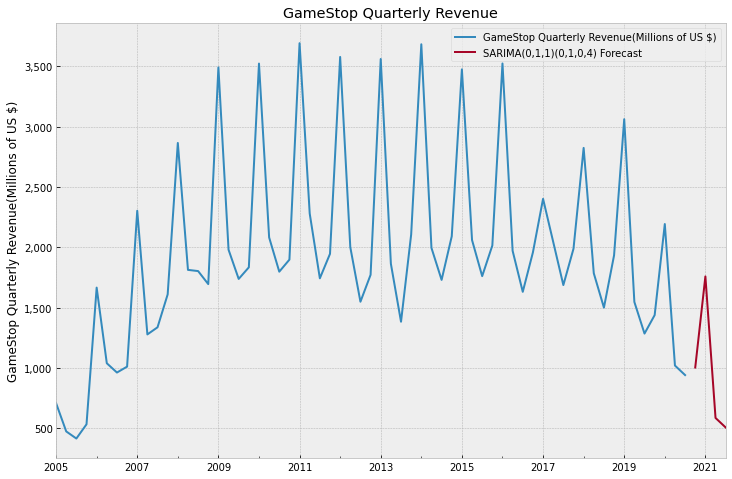

In [181]:
# Plot
title = 'GameStop Quarterly Revenue'
ylabel='GameStop Quarterly Revenue(Millions of US $)'
xlabel='' # we don't really need a label here

ax = df['GameStop Quarterly Revenue(Millions of US $)'].plot(legend=True,figsize=(12,8),title=title)
fcast.plot(legend=True)
plt.legend(loc='upper right')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

The SARIMA model looks like it performs slightly better.<br><br>
Using GameStop as a proxy for console and PC gaming retail sales, we expect a significant drop in sales to levels that have not been seen since 2005/2006. The reasons for this are beyond the scope of this analysis. However, we are able to make some educated guesses as to why this might be. Some suggested reasons include:<br>
1. The COVID-19 pandemic and its effect on retail sales
2. The growth of e-commerce
3. The growth of mobile gaming<br><br>

We could look into exogenous variables to account for the pandemic, or build a VAR model to account for the e-commerce and mobile gaming factors.